# <p style="text-align: center;">Traffic Sentiment Analysis</p>

## Introduction

### Dataset

The data for the exercise is the Pakistani Traffic Sentiment Analysis dataset from Kaggle. This dataset comprises two columns: 'Text' and 'Sentiment.' The 'Text' column encompasses free-floating texts regarding Pakistani traffic, encompassing both positive and negative reviews. The 'Sentiment' column is labeled as 0 for the positive review and 1 for the negative view. 

For example, the text is ‘Accident near Naval Anchorage, May ALLAH keep the passengers safe’ is labelled ‘1’ representing a negative sentiment. The text, ‘Khayaban Sir Syed Rd road is free’ is labelled as ‘0’ representing a positive sentiment. 

## Imports and Setup

In [203]:
import pandas as pd

df = pd.read_csv('Pakistani Traffic sentiment Analysis.csv')
df.head()

,Text,Sentiment
0,Adayala road is clear,0
1,Traffic jam from parbat rd to nazim-ud-din rd ...,1
2,Mandra is clear,0
3,Fort street is clear,0
4,"Mashriq Hotel towards Fawara Chowk, City Sadda...",1


## Vizualisation of the dataset

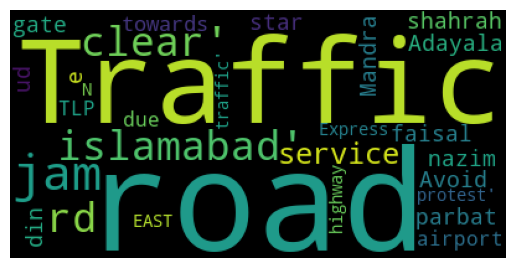

In [204]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
text = df['Text'].values

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [205]:
df.describe()

,Sentiment
count,2109.000000
mean,0.521100
std,0.499673
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2109 entries, 0 to 2108
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       2109 non-null   object
 1   Sentiment  2109 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 33.1+ KB


In [207]:
df.nunique()

Text         2083
Sentiment       2
dtype: int64

We can see that df.nunique() $\neq$ df.shape[0], so there are duplicate rows in the dataset. Let's remove them.

In [208]:
df.drop_duplicates(inplace=True)

In [209]:
X = df['Text']
y = df['Sentiment']

We'll use the classical 80/20 split

In [210]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Vectorization

In [211]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
#(1) CountVectorizer
countvectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english',min_df=20)

#(2) #HashingVectorizer
hashingvectorizer = HashingVectorizer(ngram_range=(1, 2), n_features=200)

#(3)TfidfVectorizer
tfidvectorizer = TfidfVectorizer(
    min_df=20,
    norm='l2',
    smooth_idf=True,
    use_idf=True,
    ngram_range=(1, 1),
    stop_words='english'
    )

In [212]:
X_train_countvectorized = countvectorizer.fit_transform(X_train)
X_test_countvectorized = countvectorizer.transform(X_test)
X_train_hashingvectorized = hashingvectorizer.fit_transform(X_train)
X_test_hashingvectorized = hashingvectorizer.transform(X_test)
X_train_tfidvectorized = tfidvectorizer.fit_transform(X_train)
X_test_tfidvectorized = tfidvectorizer.transform(X_test)

## Logistic Regression


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/sebastienlemasne/anaconda3/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/sebastienlemasne/anaconda3/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/sebastienlemasne/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 180, in <module>
    exitcode = process_obj._bootstrap()
  File "/Users/sebastienlemasne/anaconda3/lib/python3.10/multiprocessing/proc

Best Hyperparameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.9497607655502392


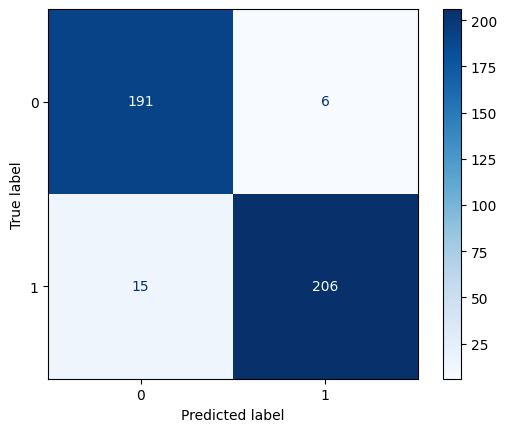

In [213]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay as cmd

# Logistic Regression with CountVectorizer

lr = LogisticRegression()
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_countvectorized, y_train)
best_lr_cv = grid.best_estimator_

y_pred = best_lr_cv.predict(X_test_countvectorized)

accuracy = accuracy_score(y_test, y_pred)
print(f'Best Hyperparameters: {grid.best_params_}')
print(f'Accuracy: {accuracy}')

cm = confusion_matrix(y_test, y_pred)
disp = cmd(confusion_matrix=cm, display_labels=best_lr_cv.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

auc_lr_cv = roc_auc_score(y_test, best_lr_cv.decision_function(X_test_countvectorized))
fpr_lr_cv, tpr_lr_cv, thresholds = roc_curve(y_test, best_lr_cv.decision_function(X_test_countvectorized))


Best Hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.9330143540669856


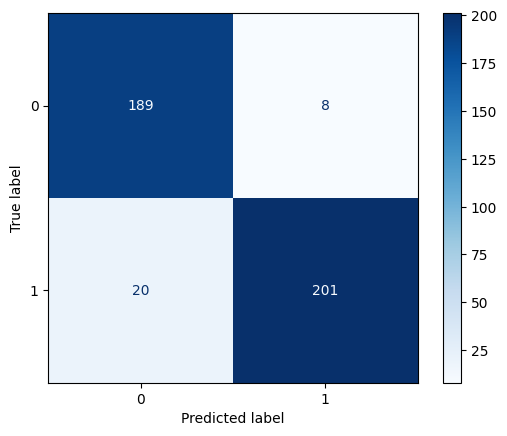

In [214]:
# Logistic Regression with HashingVectorizer

lr = LogisticRegression()
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_hashingvectorized, y_train)
best_lr_hv = grid.best_estimator_

y_pred = best_lr_hv.predict(X_test_hashingvectorized)

accuracy = accuracy_score(y_test, y_pred)
print(f'Best Hyperparameters: {grid.best_params_}')
print(f'Accuracy: {accuracy}')

cm = confusion_matrix(y_test, y_pred)
disp = cmd(confusion_matrix=cm, display_labels=best_lr_hv.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

auc_lr_hv = roc_auc_score(y_test, best_lr_hv.decision_function(X_test_hashingvectorized))
fpr_lr_hv, tpr_lr_hv, thresholds = roc_curve(y_test, best_lr_hv.decision_function(X_test_hashingvectorized))


Best Hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.9569377990430622


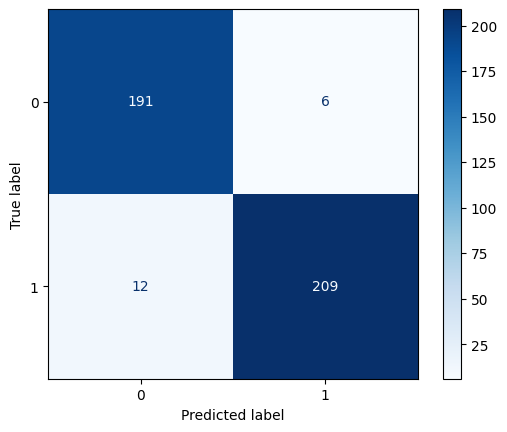

In [215]:
# Logistic Regression with TfidfVectorizer

lr = LogisticRegression()
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_tfidvectorized, y_train)
best_lr_tv = grid.best_estimator_

y_pred = best_lr_tv.predict(X_test_tfidvectorized)

accuracy = accuracy_score(y_test, y_pred)
print(f'Best Hyperparameters: {grid.best_params_}')
print(f'Accuracy: {accuracy}')

cm = confusion_matrix(y_test, y_pred)
disp = cmd(confusion_matrix=cm, display_labels=best_lr_tv.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

auc_lr_tv = roc_auc_score(y_test, best_lr_tv.decision_function(X_test_tfidvectorized))
fpr_lr_tv, tpr_lr_tv, thresholds = roc_curve(y_test, best_lr_tv.decision_function(X_test_tfidvectorized))




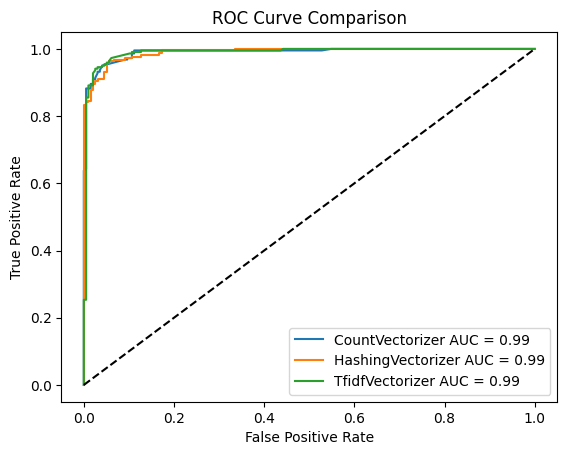

In [216]:
plt.plot(fpr_lr_cv, tpr_lr_cv, label=f'CountVectorizer AUC = {auc_lr_cv:.2f}')
plt.plot(fpr_lr_hv, tpr_lr_hv, label=f'HashingVectorizer AUC = {auc_lr_hv:.2f}')
plt.plot(fpr_lr_tv, tpr_lr_tv, label=f'TfidfVectorizer AUC = {auc_lr_tv:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

## K Nearest Neighbors

Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy: 0.930622009569378


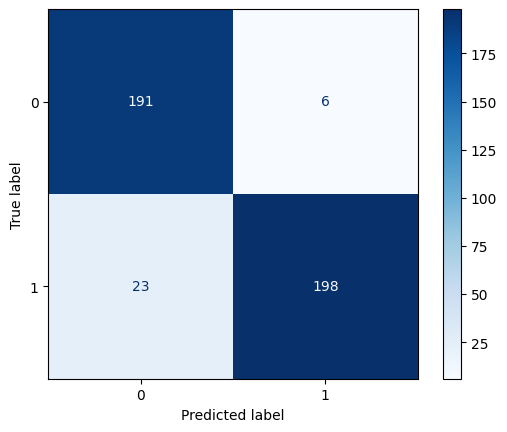

In [217]:
from sklearn.neighbors import KNeighborsClassifier

# KNN with CountVectorizer

knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_countvectorized, y_train)
best_knn_cv = grid.best_estimator_

y_pred = best_knn_cv.predict(X_test_countvectorized)

accuracy = accuracy_score(y_test, y_pred)
print(f'Best Hyperparameters: {grid.best_params_}')
print(f'Accuracy: {accuracy}')
cm = confusion_matrix(y_test, y_pred)
disp = cmd(confusion_matrix=cm, display_labels=best_knn_cv.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

auc_knn_cv = roc_auc_score(y_test, best_knn_cv.predict_proba(X_test_countvectorized)[:, 1])
fpr_knn_cv, tpr_knn_cv, thresholds = roc_curve(y_test, best_knn_cv.predict_proba(X_test_countvectorized)[:, 1])

Best Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
Accuracy: 0.9521531100478469


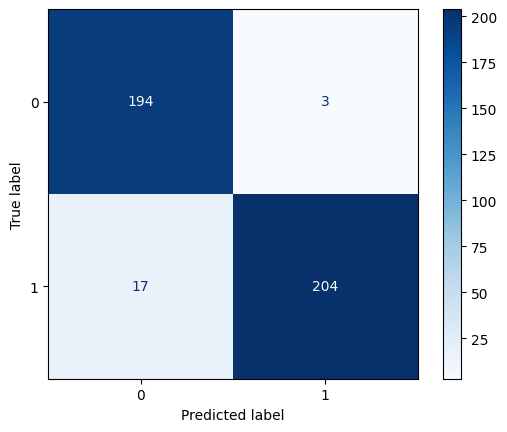

In [218]:
# KNN with HashingVectorizer

knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_hashingvectorized, y_train)
best_knn_hv = grid.best_estimator_
y_pred = best_knn_hv.predict(X_test_hashingvectorized)

accuracy = accuracy_score(y_test, y_pred)
print(f'Best Hyperparameters: {grid.best_params_}')
print(f'Accuracy: {accuracy}')

cm = confusion_matrix(y_test, y_pred)
disp = cmd(confusion_matrix=cm, display_labels=best_knn_hv.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

auc_knn_hv = roc_auc_score(y_test, best_knn_hv.predict_proba(X_test_hashingvectorized.toarray())[:, 1])
fpr_knn_hv, tpr_knn_hv, thresholds = roc_curve(y_test, best_knn_hv.predict_proba(X_test_hashingvectorized.toarray())[:, 1])

Best Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
Accuracy: 0.9234449760765551


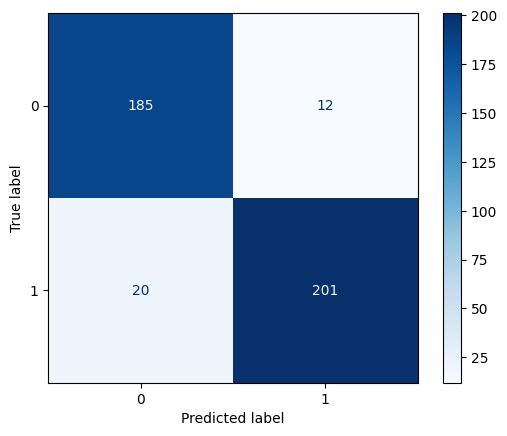

In [219]:
# KNN with TfidfVectorizer

knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_tfidvectorized, y_train)
best_knn_tv = grid.best_estimator_
y_pred = best_knn_tv.predict(X_test_tfidvectorized)

accuracy = accuracy_score(y_test, y_pred)
print(f'Best Hyperparameters: {grid.best_params_}')
print(f'Accuracy: {accuracy}')

cm = confusion_matrix(y_test, y_pred)
disp = cmd(confusion_matrix=cm, display_labels=best_knn_tv.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

auc_knn_tv = roc_auc_score(y_test, best_knn_tv.predict_proba(X_test_tfidvectorized)[:, 1])
fpr_knn_tv, tpr_knn_tv, thresholds = roc_curve(y_test, best_knn_tv.predict_proba(X_test_tfidvectorized)[:, 1])

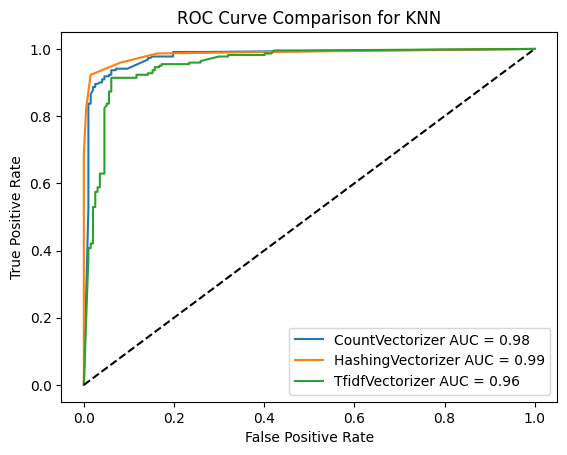

In [220]:
plt.plot(fpr_knn_cv, tpr_knn_cv, label=f'CountVectorizer AUC = {auc_knn_cv:.2f}')
plt.plot(fpr_knn_hv, tpr_knn_hv, label=f'HashingVectorizer AUC = {auc_knn_hv:.2f}')
plt.plot(fpr_knn_tv, tpr_knn_tv, label=f'TfidfVectorizer AUC = {auc_knn_tv:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for KNN')
plt.legend()
plt.show()

## Random Forest

From the results, it is evident that Logistic Regression outperforms KNN across all vectorization techniques in terms of accuracy and AUC scores. Among the vectorizers, TfidfVectorizer consistently provides the best performance for both classifiers. Therefore, for this sentiment analysis task, Logistic Regression with TfidfVectorizer is the recommended approach.

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.9521531100478469


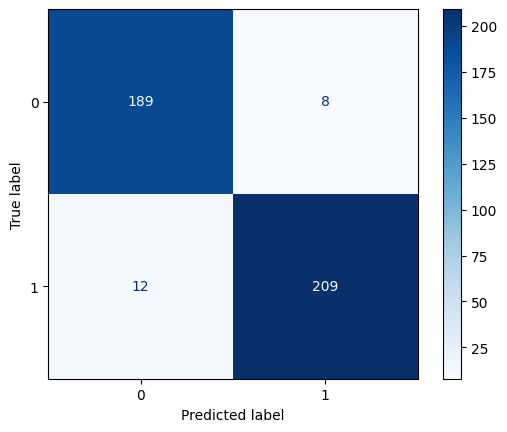

In [221]:
from sklearn.ensemble import RandomForestClassifier

# RF with CountVectorizer

rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_countvectorized, y_train)
best_rf_cv = grid.best_estimator_
y_pred = best_rf_cv.predict(X_test_countvectorized)

accuracy = accuracy_score(y_test, y_pred)
print(f'Best Hyperparameters: {grid.best_params_}')
print(f'Accuracy: {accuracy}')
cm = confusion_matrix(y_test, y_pred)
disp = cmd(confusion_matrix=cm, display_labels=best_rf_cv.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

auc_rf_cv = roc_auc_score(y_test, best_rf_cv.predict_proba(X_test_countvectorized)[:, 1])
fpr_rf_cv, tpr_rf_cv, thresholds = roc_curve(y_test, best_rf_cv.predict_proba(X_test_countvectorized)[:, 1])

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.9808612440191388


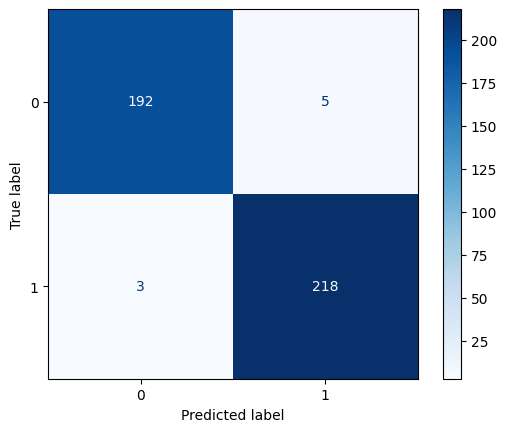

In [222]:
# RF with HashingVectorizer

rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_hashingvectorized, y_train)
best_rf_hv = grid.best_estimator_

y_pred = best_rf_hv.predict(X_test_hashingvectorized)

accuracy = accuracy_score(y_test, y_pred)
print(f'Best Hyperparameters: {grid.best_params_}')
print(f'Accuracy: {accuracy}')
cm = confusion_matrix(y_test, y_pred)
disp = cmd(confusion_matrix=cm, display_labels=best_rf_hv.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

auc_rf_hv = roc_auc_score(y_test, best_rf_hv.predict_proba(X_test_hashingvectorized.toarray())[:, 1])
fpr_rf_hv, tpr_rf_hv, thresholds = roc_curve(y_test, best_rf_hv.predict_proba(X_test_hashingvectorized.toarray())[:, 1])


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.9569377990430622


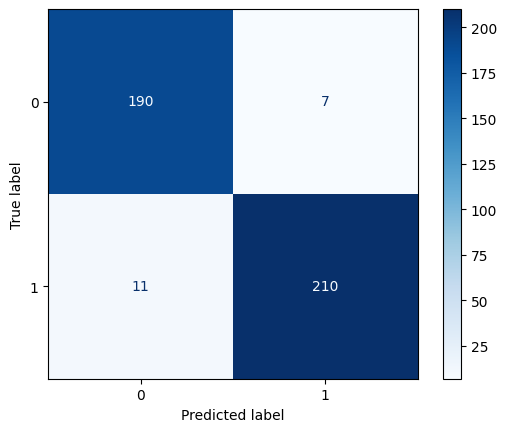

In [223]:
# RF with TfidfVectorizer

rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_tfidvectorized, y_train)
best_rf_tv = grid.best_estimator_

y_pred = best_rf_tv.predict(X_test_tfidvectorized)

accuracy = accuracy_score(y_test, y_pred)
print(f'Best Hyperparameters: {grid.best_params_}')
print(f'Accuracy: {accuracy}')
cm = confusion_matrix(y_test, y_pred)
disp = cmd(confusion_matrix=cm, display_labels=best_rf_tv.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

auc_rf_tv = roc_auc_score(y_test, best_rf_tv.predict_proba(X_test_tfidvectorized)[:, 1])
fpr_rf_tv, tpr_rf_tv, thresholds = roc_curve(y_test, best_rf_tv.predict_proba(X_test_tfidvectorized)[:, 1])


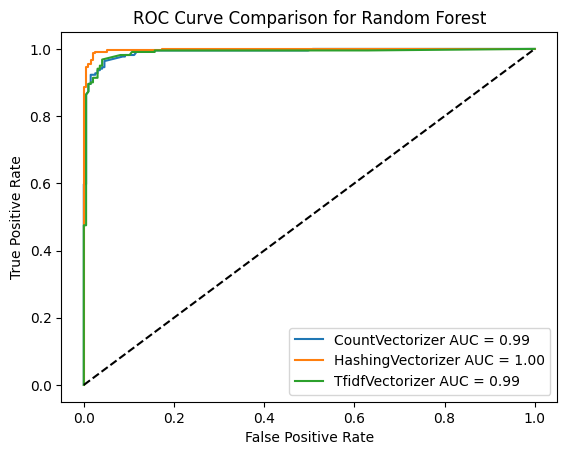

In [224]:
plt.plot(fpr_rf_cv, tpr_rf_cv, label=f'CountVectorizer AUC = {auc_rf_cv:.2f}')
plt.plot(fpr_rf_hv, tpr_rf_hv, label=f'HashingVectorizer AUC = {auc_rf_hv:.2f}')
plt.plot(fpr_rf_tv, tpr_rf_tv, label=f'TfidfVectorizer AUC = {auc_rf_tv:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for Random Forest')
plt.legend()
plt.show()

## Support Vector Machine

Best Hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.9497607655502392


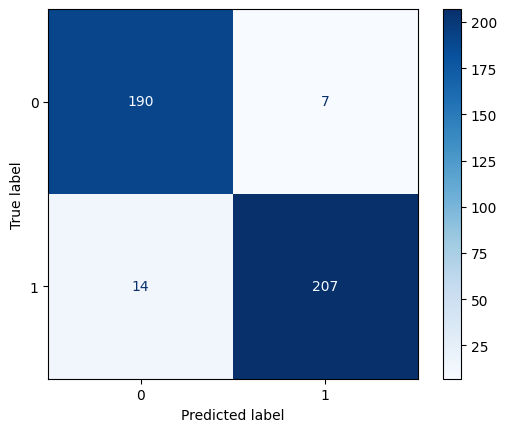

In [225]:
from sklearn.svm import SVC

# SVM with CountVectorizer

svm = SVC(probability=True)
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_countvectorized, y_train)
best_svm_cv = grid.best_estimator_

y_pred = best_svm_cv.predict(X_test_countvectorized)

accuracy = accuracy_score(y_test, y_pred)
print(f'Best Hyperparameters: {grid.best_params_}')
print(f'Accuracy: {accuracy}')
cm = confusion_matrix(y_test, y_pred)
disp = cmd(confusion_matrix=cm, display_labels=best_svm_cv.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

auc_svm_cv = roc_auc_score(y_test, best_svm_cv.predict_proba(X_test_countvectorized)[:, 1])
fpr_svm_cv, tpr_svm_cv, thresholds = roc_curve(y_test, best_svm_cv.predict_proba(X_test_countvectorized)[:, 1])

Best Hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.9736842105263158


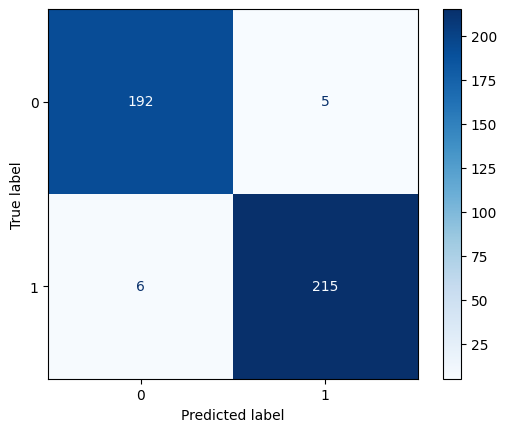

In [226]:
# SVM with HashingVectorizer

svm = SVC(probability=True)
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_hashingvectorized, y_train)
best_svm_hv = grid.best_estimator_

y_pred = best_svm_hv.predict(X_test_hashingvectorized)

accuracy = accuracy_score(y_test, y_pred)
print(f'Best Hyperparameters: {grid.best_params_}')
print(f'Accuracy: {accuracy}')
cm = confusion_matrix(y_test, y_pred)
disp = cmd(confusion_matrix=cm, display_labels=best_svm_hv.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

auc_svm_hv = roc_auc_score(y_test, best_svm_hv.predict_proba(X_test_hashingvectorized.toarray())[:, 1])
fpr_svm_hv, tpr_svm_hv, thresholds = roc_curve(y_test, best_svm_hv.predict_proba(X_test_hashingvectorized.toarray())[:, 1])

Best Hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.9497607655502392


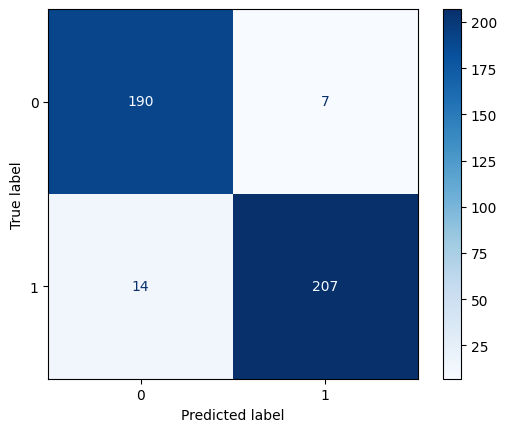

In [227]:
# SVM with TfidfVectorizer

svm = SVC(probability=True)
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_tfidvectorized, y_train)
best_svm_tv = grid.best_estimator_

y_pred = best_svm_tv.predict(X_test_tfidvectorized)

accuracy = accuracy_score(y_test, y_pred)
print(f'Best Hyperparameters: {grid.best_params_}')
print(f'Accuracy: {accuracy}')
cm = confusion_matrix(y_test, y_pred)
disp = cmd(confusion_matrix=cm, display_labels=best_svm_tv.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

auc_svm_tv = roc_auc_score(y_test, best_svm_tv.predict_proba(X_test_tfidvectorized)[:, 1])
fpr_svm_tv, tpr_svm_tv, thresholds = roc_curve(y_test, best_svm_tv.predict_proba(X_test_tfidvectorized)[:, 1])

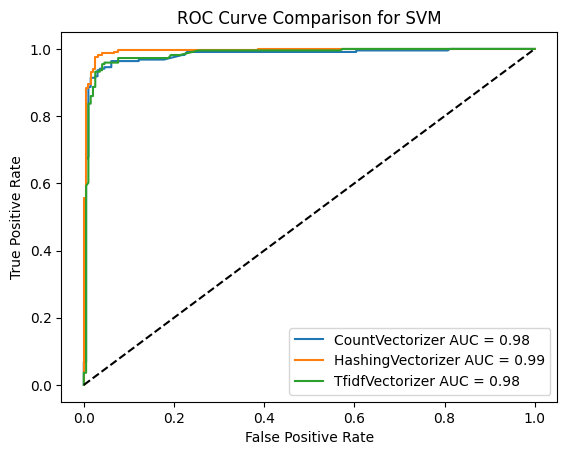

In [228]:
plt.plot(fpr_svm_cv, tpr_svm_cv, label=f'CountVectorizer AUC = {auc_svm_cv:.2f}')
plt.plot(fpr_svm_hv, tpr_svm_hv, label=f'HashingVectorizer AUC = {auc_svm_hv:.2f}')
plt.plot(fpr_svm_tv, tpr_svm_tv, label=f'TfidfVectorizer AUC = {auc_svm_tv:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for SVM')
plt.legend()
plt.show()

## Naive Bayes

Best Hyperparameters: {'alpha': 1, 'force_alpha': True}
Accuracy: 0.9473684210526315


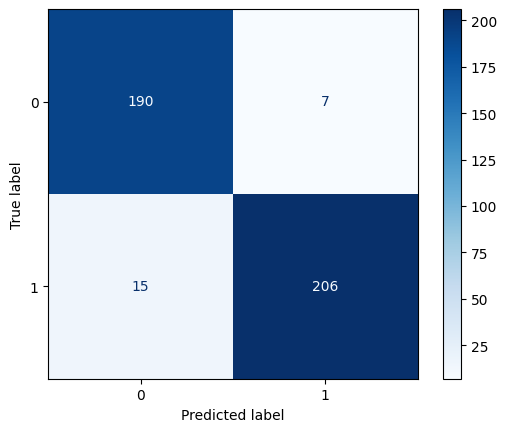

In [229]:
from sklearn.naive_bayes import BernoulliNB

# NB with CountVectorizer

nb = BernoulliNB()
param_grid = {
    'alpha': [0.1, 0.5, 1],
    'force_alpha': [True,False]
    }

grid = GridSearchCV(nb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_countvectorized, y_train)
best_nb_cv = grid.best_estimator_

y_pred = best_nb_cv.predict(X_test_countvectorized)

accuracy = accuracy_score(y_test, y_pred)
print(f'Best Hyperparameters: {grid.best_params_}')
print(f'Accuracy: {accuracy}')
cm = confusion_matrix(y_test, y_pred)
disp = cmd(confusion_matrix=cm, display_labels=best_nb_cv.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

auc_nb_cv = roc_auc_score(y_test, best_nb_cv.predict_proba(X_test_countvectorized)[:, 1])
fpr_nb_cv, tpr_nb_cv, thresholds = roc_curve(y_test, best_nb_cv.predict_proba(X_test_countvectorized)[:, 1])

Best Hyperparameters: {'alpha': 0.1, 'force_alpha': True}
Accuracy: 0.8373205741626795


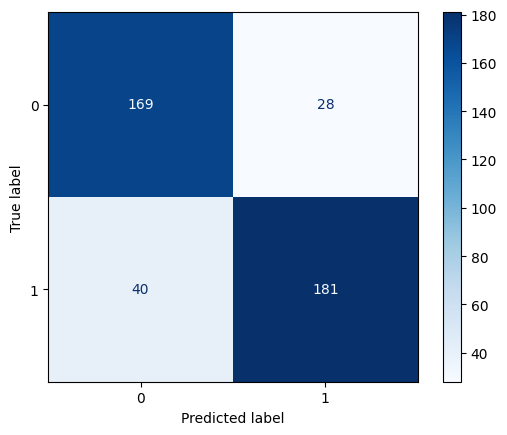

In [230]:
# NB with HashingVectorizer

nb = BernoulliNB()
param_grid = {
    'alpha': [0.1, 0.5, 1],
    'force_alpha': [True,False]
    }

grid = GridSearchCV(nb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_hashingvectorized, y_train)
best_nb_hv = grid.best_estimator_

y_pred = best_nb_hv.predict(X_test_hashingvectorized)

accuracy = accuracy_score(y_test, y_pred)
print(f'Best Hyperparameters: {grid.best_params_}')
print(f'Accuracy: {accuracy}')
cm = confusion_matrix(y_test, y_pred)
disp = cmd(confusion_matrix=cm, display_labels=best_nb_hv.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

auc_nb_hv = roc_auc_score(y_test, best_nb_hv.predict_proba(X_test_hashingvectorized.toarray())[:, 1])
fpr_nb_hv, tpr_nb_hv, thresholds = roc_curve(y_test, best_nb_hv.predict_proba(X_test_hashingvectorized.toarray())[:, 1])

Best Hyperparameters: {'alpha': 1, 'force_alpha': True}
Accuracy: 0.9449760765550239


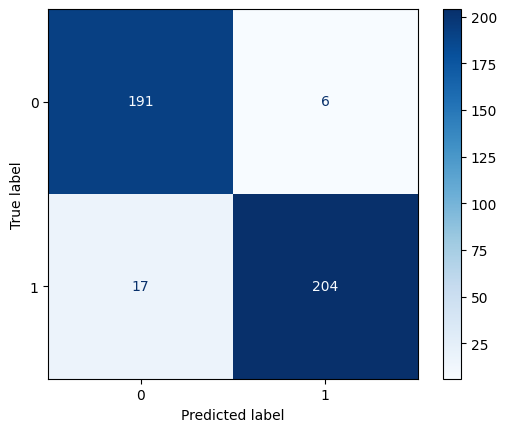

In [231]:
# NB with TfidfVectorizer

nb = BernoulliNB()
param_grid = {
    'alpha': [0.1, 0.5, 1],
    'force_alpha': [True,False]
    }

grid = GridSearchCV(nb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_tfidvectorized, y_train)
best_nb_tv = grid.best_estimator_

y_pred = best_nb_tv.predict(X_test_tfidvectorized)

accuracy = accuracy_score(y_test, y_pred)
print(f'Best Hyperparameters: {grid.best_params_}')
print(f'Accuracy: {accuracy}')
cm = confusion_matrix(y_test, y_pred)
disp = cmd(confusion_matrix=cm, display_labels=best_nb_tv.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

auc_nb_tv = roc_auc_score(y_test, best_nb_tv.predict_proba(X_test_tfidvectorized)[:, 1])
fpr_nb_tv, tpr_nb_tv, thresholds = roc_curve(y_test, best_nb_tv.predict_proba(X_test_tfidvectorized)[:, 1])

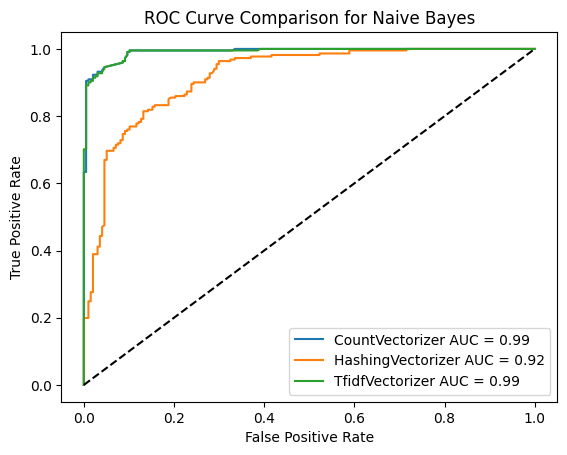

In [232]:
plt.plot(fpr_nb_cv, tpr_nb_cv, label=f'CountVectorizer AUC = {auc_nb_cv:.2f}')
plt.plot(fpr_nb_hv, tpr_nb_hv, label=f'HashingVectorizer AUC = {auc_nb_hv:.2f}')
plt.plot(fpr_nb_tv, tpr_nb_tv, label=f'TfidfVectorizer AUC = {auc_nb_tv:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for Naive Bayes')
plt.legend()
plt.show()


# Results

In [233]:
import pandas as pd
from IPython.display import display

results = {
    'Technique': ['Logistic Regression', 'Logistic Regression', 'Logistic Regression',
                  'KNN', 'KNN', 'KNN',
                  'Random Forest', 'Random Forest', 'Random Forest',
                  'SVM', 'SVM', 'SVM',
                  'Naive Bayes', 'Naive Bayes', 'Naive Bayes'],
    'Vectorizer': ['CountVectorizer', 'HashingVectorizer', 'TfidfVectorizer',
                   'CountVectorizer', 'HashingVectorizer', 'TfidfVectorizer',
                   'CountVectorizer', 'HashingVectorizer', 'TfidfVectorizer',
                   'CountVectorizer', 'HashingVectorizer', 'TfidfVectorizer',
                   'CountVectorizer', 'HashingVectorizer', 'TfidfVectorizer'],
    'Accuracy': [accuracy_score(y_test, best_lr_cv.predict(X_test_countvectorized)),
                 accuracy_score(y_test, best_lr_hv.predict(X_test_hashingvectorized)),
                 accuracy_score(y_test, best_lr_tv.predict(X_test_tfidvectorized)),
                 accuracy_score(y_test, best_knn_cv.predict(X_test_countvectorized)),
                 accuracy_score(y_test, best_knn_hv.predict(X_test_hashingvectorized)),
                 accuracy_score(y_test, best_knn_tv.predict(X_test_tfidvectorized)),
                 accuracy_score(y_test, best_rf_cv.predict(X_test_countvectorized)),
                 accuracy_score(y_test, best_rf_hv.predict(X_test_hashingvectorized)),
                 accuracy_score(y_test, best_rf_tv.predict(X_test_tfidvectorized)),
                 accuracy_score(y_test, best_svm_cv.predict(X_test_countvectorized)),
                 accuracy_score(y_test, best_svm_hv.predict(X_test_hashingvectorized)),
                 accuracy_score(y_test, best_svm_tv.predict(X_test_tfidvectorized)),
                 accuracy_score(y_test, best_nb_cv.predict(X_test_countvectorized)),
                 accuracy_score(y_test, best_nb_hv.predict(X_test_hashingvectorized)),
                 accuracy_score(y_test, best_nb_tv.predict(X_test_tfidvectorized))],
    'AUC': [auc_lr_cv, auc_lr_hv, auc_lr_tv,
            auc_knn_cv, auc_knn_hv, auc_knn_tv,
            auc_rf_cv, auc_rf_hv, auc_rf_tv,
            auc_svm_cv, auc_svm_hv, auc_svm_tv,
            auc_nb_cv, auc_nb_hv, auc_nb_tv],
    'Approx. Computation Time': ['<1s', '<1s', '<1s',
                         '<1s', '<1s', '<1s',
                         '14s', '24s', '17s',
                         '2s', '7s', '2s',
                         '<1s', '<1s', '<1s'] 
}

comparison_df = pd.DataFrame(results)


display(
    comparison_df.style
        .format({"Accuracy": "{:.3f}", "AUC": "{:.3f}"})
        .set_caption("Comparison of techniques and vectorizers")
        .highlight_max(subset=["Accuracy", "AUC",], color="lightgreen", axis=0)
)

,Technique,Vectorizer,Accuracy,AUC,Approx. Computation Time
0,Logistic Regression,CountVectorizer,0.950,0.990,<1s
1,Logistic Regression,HashingVectorizer,0.933,0.990,<1s
2,Logistic Regression,TfidfVectorizer,0.957,0.990,<1s
3,KNN,CountVectorizer,0.931,0.978,<1s
4,KNN,HashingVectorizer,0.952,0.986,<1s
5,KNN,TfidfVectorizer,0.923,0.956,<1s
6,Random Forest,CountVectorizer,0.952,0.991,14s
7,Random Forest,HashingVectorizer,0.981,0.998,24s
8,Random Forest,TfidfVectorizer,0.957,0.989,17s
9,SVM,CountVectorizer,0.950,0.981,2s
